In [1]:
import raman_rabi
from raman_rabi import rr_model
from raman_rabi import rr_io
from raman_rabi import RRDataContainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import warnings
#warnings.filterwarnings("error")
plt.rcParams.update({'font.size': 18})

## PLOT DATA - Cluster mN=+1 Binned MAP Data, 40k steps, 500 walkers

In [ ]:
#import mN=+1 data for laser skew
data_length = 20
testfilepath = rr_io.get_example_data_file_path('21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt')
#testfilepath = rr_io.get_example_data_file_path('21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt')
mN1_data = RRDataContainer(testfilepath)
#print(mN1_data.get_df())

#skew_value_params calculated based on average height of each run
greatest = np.max(np.average(mN1_data.get_df().values, axis=1))
skew_value_params = np.average(mN1_data.get_df().values, axis=1)/greatest

#import cluster mN=+1 data
test_samples_chain = np.load('test_samples_BinnedMAP_40ksteps_500walkers.npy')
#print(test_samples_chain.shape)

#
numdim = 26
params = np.array([6.10, 16.6881, 1/63.8806, 5.01886, -np.pi/8.77273, 1/8.5871])
theta = np.concatenate( (params, skew_value_params), axis=0)
param_length = len(theta)
dataN = 10
runN = 1200
gaus_var = 10**(-3)
scale_factor = 100*100

#print(test_samples_chain.shape)
burn_in_time = 35000
samples = test_samples_chain[:,burn_in_time:,:]
#print(samples.shape)
#np.save('mN1_last100steps_500walkers.npy', samples)
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)
BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

In [ ]:
time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)
#mu = mu*np.mean(np.percentile(traces[6:len(theta), :], 50, axis=1)) #MOST IMPORTANT PART!!!!
laserindex = np.argmin(np.abs(traces[0, :] - np.percentile(traces[0, :], 50)))
laserskewave = np.average(traces[6:27, laserindex])
mu = mu*laserskewave #MOST IMPORTANT PART!!!!

#Plot over unaveraged data
plt.figure()
for iii in range(data_length):
    if iii == 0:
        plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/dataN, color='C0', label='Raw Data')
    else:
        plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/dataN, color='C0')
plt.plot(time, mu, color='r', label='MCMC')
plt.legend()
plt.xlabel('Time [$\mu$s]', fontsize=15)
plt.ylabel('Fluorescence [A.U.]', fontsize=15)
plt.title('$mN = +1$ Oscillation')
plt.savefig('mN1_rawdata.png', bbox_inches = 'tight')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
prior_mu = prior_mu*np.mean(skew_value_params)

##Compare Results
plt.figure()
#plt.plot(time, mu, color='r', label='MCMC')
plt.scatter(time, np.sum(scale_factor*mN1_data.get_df().values/(dataN*data_length), axis=0), label='Average Data')
plt.ylim([0, 40])
plt.legend()
plt.xlabel('Time [$\mu$s]', fontsize=15)
plt.ylabel('Fluorescence [A.U.]', fontsize=15)
plt.title('$mN = +1$ Oscillation')
plt.savefig('mN1_averagedata.png', bbox_inches = 'tight')
#plt.savefig('mN1_averagedata_nofit.png', bbox_inches = 'tight')
plt.show()

In [ ]:
#Look at burn in. This isn't a very realistic set up, we start with good parameters and
#then only let the walkers walk a little while
numsteps = 40000
burn_in_time = 3800
numwalkers = 500
print(parameter_samples.shape)
steps = numsteps - burn_in_time
print(steps)
print(numwalkers*steps)
print(test_samples_chain.shape)

param1 = 3

for iii in range(10):
    plt.plot(test_samples_chain[iii, :, param1])

## Cluster mN=+1 Sequential Data, 40k steps, 500 walkers

In [ ]:
#import mN=+1 data
data_length = 20
testfilepath = rr_io.get_example_data_file_path('21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt')
mN1_data = RRDataContainer(testfilepath)
#print(mN1_data.get_df())

#skew_value_params calculated based on average height of each run
greatest = np.max(np.average(mN1_data.get_df().values, axis=1))
skew_value_params = np.average(mN1_data.get_df().values, axis=1)/greatest

#import cluster mN=+1 data
test_samples_chain = np.load('test_samples_Sequential_40ksteps_500walkers.npy')
print(test_samples_chain.shape)

#
numdim = 26
params= np.array([8.36254404e+00, 2.70752593e+01, 1.62175302e-02, 8.43378839e+00, -3.24751892e-01, 1.33240464e-01])
theta = np.concatenate( (params, skew_value_params), axis=0)
param_length = len(theta)
dataN = 10
runN = 1200
gaus_var = 10**(-3)
scale_factor = 100*100

#print(test_samples_chain.shape)
burn_in_time = 35000
samples = test_samples_chain[:,burn_in_time:,:]
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)
BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

In [ ]:
time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)
mu = mu*np.mean(np.percentile(traces[6:len(theta), :], 50, axis=1)) #MOST IMPORTANT PART!!!!
#we multiply mu by the 50th percentile
#mean of laser skew

#Plot over unaveraged data
plt.figure()
for iii in range(data_length):
    plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/dataN, color='b')
plt.plot(time, mu, color='k')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
prior_mu = prior_mu*np.mean(skew_value_params)
##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.plot(time, paper_mu, color='k', label='Paper')
plt.plot(time, prior_mu, color='b', label='Guesses')
plt.legend()
plt.show()

In [ ]:
#Look at burn in. This isn't a very realistic set up, we start with good parameters and
#then only let the walkers walk a little while
print(parameter_samples.shape)
steps = numsteps - burn_in_time
print(steps)
print(numwalkers*steps)
print(test_samples_chain.shape)

param1 = 12

for iii in range(10):
    plt.plot(test_samples_chain[iii, :, param1])

## PLOT DATA - Cluster mN=0 Binned MAP Data, 40k steps, 500 walkers

In [ ]:
#import mN=+0 data
data_length = 30
testfilepath = rr_io.get_example_data_file_path('23.33.41_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout- -800 MHz, ND0.7 Vel1, Presel 5 (APD2, Win 3)_ID10718_image.txt')
mN1_data = RRDataContainer(testfilepath)
#print(mN1_data.get_df())

#skew_value_params calculated based on average height of each run
greatest = np.max(np.average(mN1_data.get_df().values, axis=1))
skew_value_params = np.average(mN1_data.get_df().values, axis=1)/greatest
#print(skew_value_params.shape)

#import cluster mN=+1
test_samples_chain = np.load('test_samples_MN0_BinnedMAP_40ksteps_500walkers.npy')
#test_samples_chain = np.load('test_samples_MN0_NewGuesses_40ksteps_500walkers.npy')
print(test_samples_chain.shape)

#
numdim = 36
params = np.array([28.589, -16.6311, 1/70, -5.8444, -np.pi/8.37905, 1/9.43712])
theta = np.concatenate( (params, skew_value_params), axis=0)
param_length = len(theta)
dataN = 30
runN = 2400
gaus_var = 10**(-3)
scale_factor = 100*100
numsteps = 40000
numwalkers = 500

#print(test_samples_chain.shape)
burn_in_time = 35000
samples = test_samples_chain[:,burn_in_time:,:]
np.save('mN0_last100steps_500walkers.npy', samples)
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)
BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

In [ ]:
time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)
#mu = mu*np.mean(np.percentile(traces[6:len(theta), :], 50, axis=1)) #MOST IMPORTANT PART!!!!
laserindex = np.argmin(np.abs(traces[0, :] - np.percentile(traces[0, :], 50)))
laserskewave = np.average(traces[6:27, laserindex])
mu = mu*laserskewave #MOST IMPORTANT PART!!!!

#Plot over unaveraged data
plt.figure()
for iii in range(data_length):
    if iii == 0:
        plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/dataN, color='C0', label='Raw Data')
    else:
        plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/dataN, color='C0')
plt.plot(time, mu, color='r', label='MCMC')
plt.legend()
plt.xlabel('Time [$\mu$s]', fontsize=15)
plt.ylabel('Fluorescence [A.U.]', fontsize=15)
plt.title('$mN = 0$ Oscillation')
plt.savefig('mN0_rawdata.png', bbox_inches = 'tight')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
#time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
prior_mu = prior_mu*np.mean(skew_value_params)

##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.scatter(time, np.sum(scale_factor*mN1_data.get_df().values/(dataN*data_length), axis=0), label='Average Data')
plt.ylim([0, 40])
plt.legend()
plt.xlabel('Time [$\mu$s]', fontsize=15)
plt.ylabel('Fluorescence [A.U.]', fontsize=15)
plt.title('$mN = 0$ Oscillation')
plt.savefig('mN0_averagedata.png', bbox_inches = 'tight')
#plt.savefig('mN0_averagedata_nofit.png', bbox_inches = 'tight')
plt.show()

In [ ]:
#Look at burn in. This isn't a very realistic set up, we start with good parameters and
#then only let the walkers walk a little while
print(parameter_samples.shape)
steps = numsteps - burn_in_time
print(steps)
print(numwalkers*steps)
print(test_samples_chain.shape)

param1 = 5

for iii in range(10):
    plt.plot(test_samples_chain[iii, :, param1])

## Here is for the mN = +1 data

In [3]:
#import mN=+1 data
data_length = 20
testfilepath = rr_io.get_example_data_file_path('21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt')
mN1_data = RRDataContainer(testfilepath)
#print(mN1_data.get_df())

#skew_value_params calculated based on average height of each run
greatest = np.max(np.average(mN1_data.get_df().values, axis=1))
skew_value_params = np.average(mN1_data.get_df().values, axis=1)/greatest

In [7]:
#Estimates from Cluster MCMC
#params= np.array([8.36254404e+00, 2.70752593e+01, 1.62175302e-02, 8.43378839e+00, -3.24751892e-01, 1.33240464e-01])
params = np.array([6.10, 16.6881, 1/63.8806, 5.01886, -np.pi/8.77273, 1/8.5871])
theta = np.concatenate( (params, skew_value_params), axis=0)
param_length = len(theta)
dataN = 10
runN = 1200
gaus_var = 10**(-3)
scale_factor = 100*100

laserskew_priors = [  ['uniform',0,+np.inf], # BG
                      ['uniform',0,+np.inf], # Ap
                      ['uniform',0.0,+np.inf], # Gammap
                      ['uniform',0,+np.inf], # Ah
                      ['uniform',-np.inf, 0],# Omegah
                      ['uniform',0.0,+np.inf]] # Gammadeph

laserskew_priors = laserskew_priors + [['uniform',0,1]]*data_length

# run MCMC on the test data and see if it's pretty close to the original theta
guesses = theta
numdim = len(guesses)
numwalkers = 200
numsteps = 4000
test_samples = rr_model.Walkers_Sampler(mN1_data, guesses, 0, 40, True, dataN, runN, gaus_var, numwalkers, numsteps, scale_factor=100*100, withlaserskew = True, priors=laserskew_priors)
#test_samples = rr_model.Walkers(mN1_data, guesses,0, 40, True, dataN, runN, scale_factor=100*100,nwalkers=numwalkers,nsteps=numsteps)
burn_in_time = 3500
samples = test_samples.chain[:,burn_in_time:,:]
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)
BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

/home/taylor/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/taylor/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Guess Parameters
[ 6.10000000e+00  1.66881000e+01  1.56542049e-02  5.01886000e+00
 -3.58108896e-01  1.16453750e-01]
MCMC Parameters
[ 1.19592549e+01  2.31568547e+01  2.07374780e-02  8.15869360e+00
 -3.27818771e-01  1.29561222e-01]

Estimated Laserskew
[0.72399672 0.75163799 0.4608927  0.6089271  0.90601965 0.78624078
 0.54033579 0.53583129 0.85667485 0.92424241 0.72481573 0.75696151
 0.72788697 0.81040131 0.67915643 0.59193284 1.         0.83579032
 0.68837019 0.82739559]
MCMC Laserskew
[0.72266879 0.76274345 0.47468392 0.6298178  0.88911798 0.79226937
 0.56515156 0.55713199 0.84697441 0.91496362 0.73957107 0.78416591
 0.73438588 0.80311407 0.68648766 0.59226788 0.96696935 0.83133619
 0.68263985 0.83065062]



In [8]:
#%debug

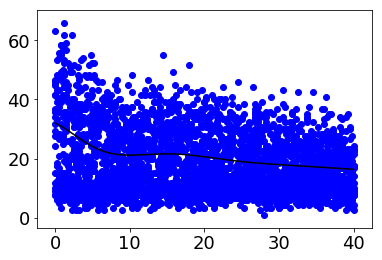

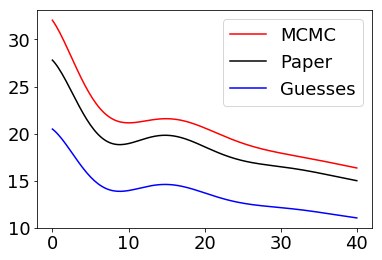

In [9]:
time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)
mu = mu*np.mean(np.percentile(traces[6:len(theta), :], 50, axis=1)) #MOST IMPORTANT PART!!!!
#we multiply mu by the 50th percentile
#mean of laser skew

#Plot over unaveraged data
plt.figure()
for iii in range(data_length):
    plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/dataN, color='b')
plt.plot(time, mu, color='k')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
prior_mu = prior_mu*np.mean(skew_value_params)
##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.plot(time, paper_mu, color='k', label='Paper')
plt.plot(time, prior_mu, color='b', label='Guesses')
plt.legend()
plt.show()

(100000, 6)
500
100000
(200, 4000, 26)


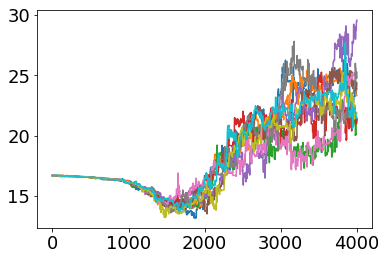

In [12]:
#Look at burn in. This isn't a very realistic set up, we start with good parameters and
#then only let the walkers walk a little while
print(parameter_samples.shape)
steps = numsteps - burn_in_time
print(steps)
print(numwalkers*steps)
print(test_samples.chain.shape)

param1 = 1

for iii in range(10):
    plt.plot(test_samples.chain[iii, :, param1])

## Here is for the mN = 0 Data

In [13]:
#import mN=+0 data
data_length = 30
testfilepath = rr_io.get_example_data_file_path('23.33.41_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout- -800 MHz, ND0.7 Vel1, Presel 5 (APD2, Win 3)_ID10718_image.txt')
mN1_data = RRDataContainer(testfilepath)
#print(mN1_data.get_df())

#skew_value_params calculated based on average height of each run
greatest = np.max(np.average(mN1_data.get_df().values, axis=1))
skew_value_params = np.average(mN1_data.get_df().values, axis=1)/greatest

In [14]:
#Estimates from Cluster MCMC
#params= np.array([8.36254404e+00, 2.70752593e+01, 1.62175302e-02, 8.43378839e+00, -3.24751892e-01, 1.33240464e-01])
params = np.array([32.589, -20.6311, 1/89.7832, -2.8444, -np.pi/9.37905, 1/7.43712])
theta = np.concatenate( (params, skew_value_params), axis=0)
param_length = len(theta)
dataN = 30
runN = 2400
scale_factor = 100*100
gaus_var = 10**(-3)

laserskew_priors = [  ['uniform',0,+np.inf], # BG
                      ['uniform',-np.inf, 0], # Ap
                      ['uniform',0.0,+np.inf], # Gammap
                      ['uniform',-np.inf, 0], # Ah
                      ['uniform',-np.inf, 0],# Omegah
                      ['uniform',0.0,+np.inf]] # Gammadeph

laserskew_priors = laserskew_priors + [['uniform',0,1]]*data_length

# run MCMC on the test data and see if it's pretty close to the original theta
guesses = theta
numdim = len(guesses)
numwalkers = 200
numsteps = 10000
test_samples = rr_model.Walkers_Sampler(mN1_data, guesses, 0, 40, True, dataN, runN, gaus_var, numwalkers, numsteps, scale_factor=100*100, withlaserskew = True, priors=laserskew_priors)
#test_samples = rr_model.Walkers(mN1_data, guesses,0, 40, True, dataN, runN, scale_factor=100*100,nwalkers=numwalkers,nsteps=numsteps)
burn_in_time = 9500
samples = test_samples.chain[:,burn_in_time:,:]
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)
BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

/home/taylor/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/taylor/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Guess Parameters
[ 3.25890000e+01 -2.06311000e+01  1.11379412e-02 -2.84440000e+00
 -3.34958514e-01  1.34460651e-01]
MCMC Parameters
[ 4.73200633e+01 -2.81130527e+01  1.91088230e-02 -4.77120355e+00
 -3.34735743e-01  1.22642665e-01]

Estimated Laserskew
[0.61733484 0.75646707 0.63320622 0.45831186 0.55817788 0.69473359
 1.         0.83530867 0.51757188 0.40647223 0.70658559 0.3972998
 0.52416778 0.73564877 0.56776255 0.69947439 0.6253736  0.6593837
 0.60105122 0.49190972 0.56951458 0.63258786 0.41976708 0.30980109
 0.50912089 0.71596413 0.83108317 0.82304442 0.7571885  0.88962177]
MCMC Laserskew
[0.62413051 0.76141009 0.67858265 0.54134376 0.59711084 0.75048778
 0.98143233 0.85152511 0.57913833 0.47042858 0.77939713 0.5191927
 0.58416392 0.76488751 0.63872618 0.72616749 0.6500287  0.71954905
 0.67695455 0.5562898  0.66883468 0.69952363 0.49887042 0.34076159
 0.59327951 0.76047682 0.90084892 0.85711997 0.82493666 0.93601441]



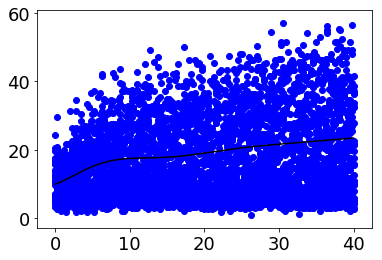

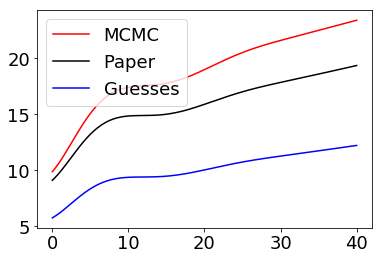

In [15]:
time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)
mu = mu*np.mean(np.percentile(traces[6:len(theta), :], 50, axis=1)) #MOST IMPORTANT PART!!!!
#we multiply mu by the 50th percentile
#mean of laser skew

#Plot over unaveraged data
plt.figure()
for iii in range(data_length):
    plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/dataN, color='b')
plt.plot(time, mu, color='k')
plt.show()

##paper values
BG = params[0]
Ap = params[1]
Gammap = params[2]
Ah = params[3]
Omegah = params[4]
Gammadeph = params[5]
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
prior_mu = prior_mu*np.mean(skew_value_params)
##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.plot(time, paper_mu, color='k', label='Paper')
plt.plot(time, prior_mu, color='b', label='Guesses')
plt.legend()
plt.show()

(100000, 6)
500
100000
(200, 10000, 36)


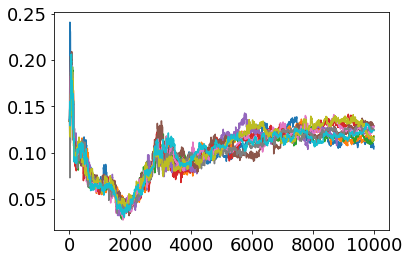

In [16]:
#Look at burn in. This isn't a very realistic set up, we start with good parameters and
#then only let the walkers walk a little while
print(parameter_samples.shape)
steps = numsteps - burn_in_time
print(steps)
print(numwalkers*steps)
print(test_samples.chain.shape)

param1 = 5

for iii in range(10):
    plt.plot(test_samples.chain[iii, :, param1])

In [ ]:
[ 4.04932775e+01 -2.20687036e+01  2.79703725e-02 -4.36041101e+00
 -3.45684964e-01  1.18924456e-01]